# Code to run and plot PCA

In [1]:
import numpy as np
import os  # For Saving to Folder
import pandas as pd
import matplotlib.pyplot as plt

import socket
import os as os
import sys as sys
import multiprocessing as mp
import itertools as it
from time import time

# For Arial Font
from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'   # Set the defaul
rcParams['font.sans-serif'] = ['Arial']

socket_name = socket.gethostname()
print(socket_name)

if socket_name.startswith("compute-"):
    print("HSM Computational partition detected.")
    path = "/n/groups/reich/hringbauer/git/punic_aDNA/"  # The Path on Midway Cluster
else:
    raise RuntimeWarning("Not compatible machine. Check!!")

os.chdir(path)  # Set the right Path (in line with Atom default)
# Show the current working directory. Should be HAPSBURG/Notebooks/ParallelRuns
print(os.getcwd())
print(f"CPU Count: {mp.cpu_count()}")
print(sys.version)

compute-a-17-76.o2.rc.hms.harvard.edu
HSM Computational partition detected.
/n/groups/reich/hringbauer/git/punic_aDNA
CPU Count: 32
3.7.4 (default, Sep 11 2019, 11:24:51) 
[GCC 6.2.0]


In [2]:
def remove_individuals(df, remove_list=["_d"], iid_col="iid"):
    """Remove indivdiuals from PCA dataframe"""
    idx = df[iid_col].str.contains("|".join(remove_list))
    df = df[~idx].copy()
    print(f"Filtering to {len(df)}/{len(idx)}")
    return df

def get_sub_iid(df, pop_list=[""], iid_col="iid"):
    """Remove indivdiuals from PCA dataframe"""
    pops = "|".join(pop_list)
    idx = df[iid_col].str.contains(pops)
    df = df[idx].copy()
    print(f"{pops} IIDs: {len(df)}/{len(idx)}")
    return df

def get_sub_pops(df, pop_list=[], pop_col="pop"):
    """Get Sub Populations"""
    pops = "|".join(pop_list)
    idx = df[pop_col].str.contains(pops)
    df = df[idx].copy()
    print(f"{pops} Found: {len(df)}/{len(idx)}")
    return df

def get_sub_pops_exact(df, pop_list=[], pop_col="pop"):
    """Get Sub Populations"""
    idx = df[pop_col].isin(pop_list)
    df = df[idx].copy()
    print(f"Found {pop_list} (exact): {len(df)}/{len(idx)}")
    return df

def split_up_df(df, col="loc"):
    """Split up Dataframe by column.
    Return column labels and dataframes"""
    locs = [l for l, _ in df.groupby(col)]
    dfs = [df for _, df in df.groupby(col)]
    return locs, dfs

####################################################
### Plotting PCA

def plot_pca(ax, df, c="gray", alpha=1.0, legend="", marker="o",
             s=30, ec=None, text=False):
    """Plot PCA onto Axis"""
    ax.scatter(-df["pc1"], df["pc2"], c=c, alpha=alpha, label=legend, 
               ec=ec, s=s, marker=marker)
    if text:
        x, y = -df["pc1"].values, df["pc2"].values
        for i, txt in enumerate(df["iid"]):
            ax.annotate(txt, (x[i], y[i]), ha="left", va="bottom", c=c)
            
def plot_pca_ho(ax, df, c="gray", alpha=1.0, legend="", marker="o",
                s=30, ec=None, text=False):
    """Plot PCA onto Axis"""
    ax.scatter(-df["pc1"], df["pc2"], c=c, alpha=alpha, label=legend, 
               ec=ec, s=s, marker=marker)
    if text:
        x, y = -df["pc1"].values, df["pc2"].values
        for i, txt in enumerate(df["iid"]):
            ax.annotate(txt[:3], (x[i], y[i]), ha="center", va="center")           

In [3]:
min_snp = 30000
#path_pca = "./output/pca/v46/20210317.punic1.v46_HO.construct_WE_NA_PCA.shrinkmodeNO.evec.txt"
#path_pca = "./output/pca/v45/20201116.punic1.v45_HO.construct_WE_NA_PCA.shrinkmode.evec.txt"
#path_pca = "./output/pca/v46/20210322.punic1.v46_HO.construct_WE_NA_PCA.smNO.outit.evec.txt"
path_pca = "./output/pca/v46/20210323.punic1.v46_HO.construct_WE_NA_PCA.smYES.outitY.evec.txt"
path_meta = "/n/groups/reich/hringbauer/Data/v46.1.anno.csv"

df = pd.read_csv(path_pca, 
                 sep=r"\s+", skiprows=1, header=None)
df.columns=["iid", "pc1", "pc2", "pc3", "pc4", "pop"]
df = remove_individuals(df, remove_list=["_d"])

df_meta = pd.read_csv(path_meta, sep=",")
df2 = df_meta[["iid", "Master ID", "loc", "n_cov_snp", 
               "mean_cov", "sex", "age", "contact"]]
df = pd.merge(df, df2, on="iid", how="left")
idx = (df["n_cov_snp"]<min_snp)
df = df[~idx]
df.loc[df["loc"].isnull(), "loc"]="not assigned"
print(f"Filtered to {len(df)} Individuals based on Min SNP: {min_snp}")

df = df.sort_values(by="n_cov_snp", ascending=False)
dup = (df["Master ID"].duplicated() & ~df["Master ID"].isnull())
df = df[~dup].copy().reset_index(drop=True)
print(f"Filtered to {len(df)} based on duplicates")

#df[df["pop"].str.contains("Lebanon")]

Filtering to 2144/2162
Filtered to 2106 Individuals based on Min SNP: 30000
Filtered to 2042 based on duplicates


### Get PCA populations

In [4]:
df_ho = get_sub_pops_exact(df, pop_list=["construct_WE_NA_PCA"])
df_is = get_sub_pops_exact(df, pop_list=["Israel_MLBA"])
df_le = get_sub_pops_exact(df, pop_list=["Lebanon_MBA.SG"])
#df_isp = get_sub_pops_exact(df, pop_list=["Israel_Phoenician"])
df_isp = get_sub_pops(df, pop_list=["Israel_Phoenician"])

df_sard = get_sub_pops(df, pop_list=["Italy_Sardinia_Punic"])
df_sard_ba = get_sub_pops_exact(df, pop_list=["Italy_Sardinia_EBA","Italy_Sardinia_BA_Nuragic"])

df_tun = get_sub_pops(df, pop_list=["Tunisia_N"])
df_vil = get_sub_iid(df, ["VIL"])
df_msr = get_sub_iid(df, ["MSR"])

df_cad = get_sub_iid(df, ["I12517|I15434|I8135"])

df_greek = get_sub_pops_exact(df, pop_list=["Greece_BA_Mycenaean"])
df_alg = get_sub_pops(df, pop_list=["Algeria_IA"])
df_spain = get_sub_pops_exact(df, pop_list=["Spain_IA"])

df_sic_mba = get_sub_pops_exact(df, pop_list=["Italy_Sicily_MBA"])

df_vill = get_sub_pops(df, pop_list=["Villaricos"], pop_col="loc")
df_vill = df_vill[(df_vill["pop"].str.contains("Punic")) & (df_vill["age"]>2000)]
df_ib = get_sub_pops(df, ["Ibiza_Punic"])
#df_sic = get_sub_pops_exact(df, ["Italy_Phoenician_Sicily"])
df_sic2 = get_sub_pops(df, ["Italy_Sicily_Punic"])
df_mar = df_sic2[df_sic2["loc"].str.contains("Marsala")].copy()
df_mot = df_sic2[df_sic2["loc"].str.contains("Motya")].copy()
df_bir = df_sic2[df_sic2["loc"].str.contains("Birgi")].copy()
df_sel = df_sic2[df_sic2["loc"].str.contains("Selinunte")].copy()
df_pal = df_sic2[df_sic2["loc"].str.contains("Palermo")].copy()

df_sic_ia = get_sub_pops_exact(df, ["Italy_Sicily_IA_Polizzello"])
df_sic_him = get_sub_pops(df, ["Sicily_Himera"])

df_eg_hell = get_sub_pops(df, ["Egypt_Hellenistic"])
df_eg_dyn = get_sub_pops(df, ["Egypt_Dynastic"])
df_meno = get_sub_pops(df, ["Menorca"])
df_kerk = get_sub_pops(df, ["Tunisia_Pun"])

Found ['construct_WE_NA_PCA'] (exact): 1196/2042
Found ['Israel_MLBA'] (exact): 31/2042
Found ['Lebanon_MBA.SG'] (exact): 5/2042
Israel_Phoenician Found: 14/2042
Italy_Sardinia_Punic Found: 20/2042
Found ['Italy_Sardinia_EBA', 'Italy_Sardinia_BA_Nuragic'] (exact): 28/2042
Tunisia_N Found: 9/2042
VIL IIDs: 6/2042
MSR IIDs: 2/2042
I12517|I15434|I8135 IIDs: 3/2042
Found ['Greece_BA_Mycenaean'] (exact): 13/2042
Algeria_IA Found: 1/2042
Found ['Spain_IA'] (exact): 21/2042
Found ['Italy_Sicily_MBA'] (exact): 4/2042
Villaricos Found: 13/2042
Ibiza_Punic Found: 1/2042
Italy_Sicily_Punic Found: 56/2042
Found ['Italy_Sicily_IA_Polizzello'] (exact): 19/2042
Sicily_Himera Found: 25/2042
Egypt_Hellenistic Found: 2/2042
Egypt_Dynastic Found: 2/2042
Menorca Found: 1/2042
Tunisia_Pun Found: 29/2042


In [5]:
df_sicr = get_sub_pops(df, ["Italy_Sicily_MBA"])

Italy_Sicily_MBA Found: 7/2042


### HO PCA shrinkmode YES outlierremoval NO

Found ['construct_WE_NA_PCA'] (exact): 1196/2042


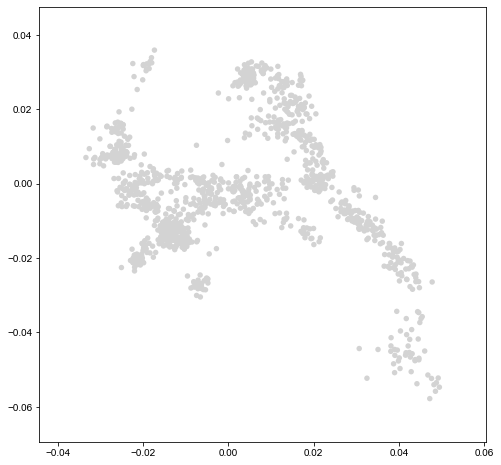

In [5]:
#savepath="./figures/pca/west_med_punic_pca.pdf"
savepath=""
#savepath=""

df_ho = get_sub_pops_exact(df, pop_list=["construct_WE_NA_PCA"])
plt.figure(figsize=(8,8))
ax = plt.gca()

plot_pca_ho(ax, df_ho, c="lightgray", text=False)

if len(savepath) > 0:
    plt.savefig(savepath, bbox_inches = 'tight', 
                pad_inches = 0, dpi=600)
    print(f"Saved to: {savepath}")
    
plt.show()

### Without Removing outliers, v46

Found: 1196/2042


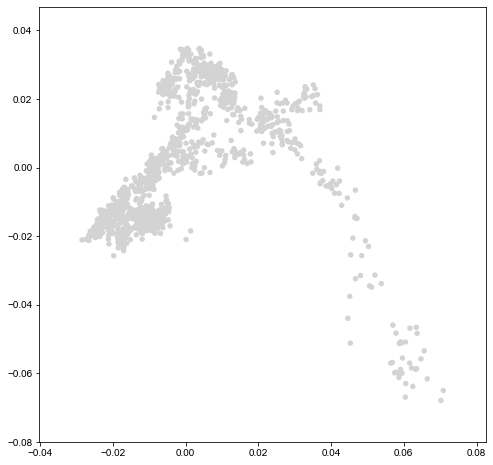

In [124]:
#savepath="./figures/pca/west_med_punic_pca.pdf"
savepath=""
#savepath=""

df_ho = get_sub_pops_exact(df, pop_list=["construct_WE_NA_PCA"])
plt.figure(figsize=(8,8))
ax = plt.gca()

plot_pca_ho(ax, df_ho, c="lightgray", text=False)

if len(savepath) > 0:
    plt.savefig(savepath, bbox_inches = 'tight', 
                pad_inches = 0, dpi=600)
    print(f"Saved to: {savepath}")
    
plt.show()

### v45 PCA

Found: 1196/1989


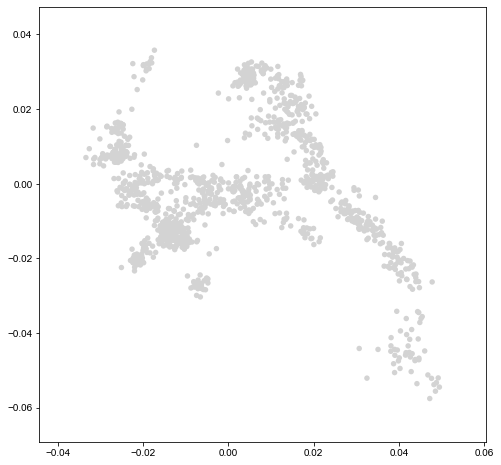

In [25]:
#savepath="./figures/pca/west_med_punic_pca.pdf"
savepath=""
#savepath=""

df_ho = get_sub_pops_exact(df, pop_list=["construct_WE_NA_PCA"])
plt.figure(figsize=(8,8))
ax = plt.gca()

plot_pca_ho(ax, df_ho, c="lightgray", text=False)

if len(savepath) > 0:
    plt.savefig(savepath, bbox_inches = 'tight', 
                pad_inches = 0, dpi=600)
    print(f"Saved to: {savepath}")
    
plt.show()

### V46 PCA

Found: 1132/1770


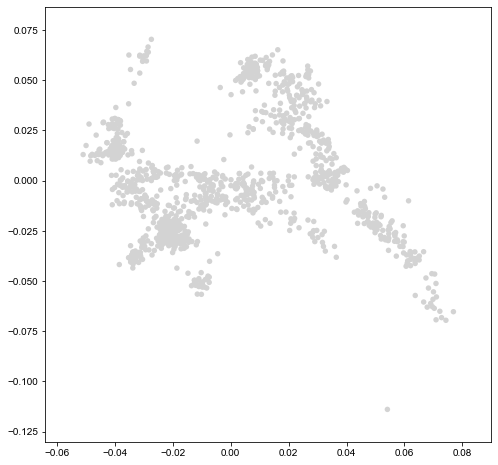

In [19]:
#savepath="./figures/pca/west_med_punic_pca.pdf"
savepath=""
#savepath=""

df_ho = get_sub_pops_exact(df, pop_list=["construct_WE_NA_PCA"])
plt.figure(figsize=(8,8))
ax = plt.gca()

plot_pca_ho(ax, df_ho, c="lightgray", text=False)

if len(savepath) > 0:
    plt.savefig(savepath, bbox_inches = 'tight', 
                pad_inches = 0, dpi=600)
    print(f"Saved to: {savepath}")
    
plt.show()

# Plot full PCA

I4800|I22232|I22236|I4798|I4799 IIDs: 5/2042
I12844 IIDs: 1/2042
I8577|I7454 IIDs: 2/2042
I12849|I7265 IIDs: 2/2042
Saved to: ./figures/pca.v46/dated_marsala.pdf


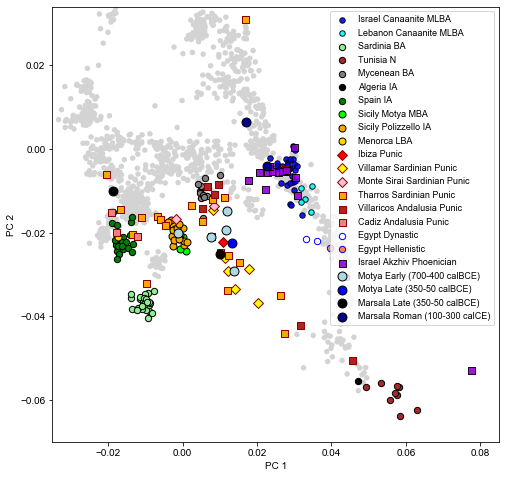

In [6]:
#savepath="./figures/pca/west_med_punic_pca.pdf"
#savepath="./figures/pca.v46/west_med_punic_pca.pdf"
savepath="./figures/pca.v46/dated_marsala.pdf"
#savepath=""

plt.figure(figsize=(8,8))
ax = plt.gca()

plot_pca_ho(ax, df_ho, c="lightgray", text=False)
plot_pca(ax, df_is, c="blue", legend="Israel Canaanite MLBA", ec="k", alpha=0.9)
plot_pca(ax, df_le, c="aqua", legend="Lebanon Canaanite MLBA", ec="k", alpha=0.9)

### Plot the Sardinian Samples
plot_pca(ax, df_sard_ba, c="lightgreen", legend="Sardinia BA", ec="k", s=40)
plot_pca(ax, df_tun, c="brown", legend="Tunisia N", ec="k", s=40)
plot_pca(ax, df_greek, c="gray", legend="Mycenean BA", ec="k", s=40)

plot_pca(ax, df_alg, c="k", legend="Algeria IA", s=40, ec="k")
plot_pca(ax, df_spain, c="green", legend="Spain IA", s=40, ec="k")

plot_pca(ax, df_sic_mba, c="lime", legend="Sicily Motya MBA", s=49, ec="k")
plot_pca(ax, df_sic_ia, c="orange", legend="Sicily Polizzello IA", s=49, ec="k")

plot_pca(ax, df_meno, c="gold", legend="Menorca LBA", ec="k", s=49)
plot_pca(ax, df_ib, c="red", legend="Ibiza Punic", ec="darkred", s=49, marker="D")

plot_pca(ax, df_vil, c="yellow", legend="Villamar Sardinian Punic", ec="darkred", s=49, marker="D")
plot_pca(ax, df_msr, c="pink", legend="Monte Sirai Sardinian Punic", ec="darkred", s=49, marker="D")

plot_pca(ax, df_sard, c="orange", legend="Tharros Sardinian Punic", ec="darkred", s=49, marker="s", text=False)

plot_pca(ax, df_vill, c="firebrick", legend="Villaricos Andalusia Punic", ec="darkred", s=49, marker="s", text=False)
plot_pca(ax, df_cad, c="lightcoral", legend="Cadiz Andalusia Punic", ec="darkred", s=49, marker="s", text=False)

#plot_pca(ax, df_kerk, c="red", legend="Kerkouane Punic", ec="darkred", s=49, marker="s", text=False)

plot_pca(ax, df_eg_dyn, c="w", legend="Egypt Dynastic", ec="blue", s=40, marker="o")
plot_pca(ax, df_eg_hell, c="coral", legend="Egypt Hellenistic", ec="blue", s=40, marker="o")

plot_pca(ax, df_isp, c="darkviolet", legend="Israel Akzhiv Phoenician", ec="k", s=49, marker="s", alpha=0.9)

#plot_pca(ax, df_sic, c="w", legend="Sicilly Punic", ec="blue", s=70, marker="s")
#plot_pca(ax, df_sic2, c="coral", legend="Sicilly Punic2", ec="blue", s=70, marker="s")
#plot_pca(ax, df_sic_him, c="red", legend="Sicily Himera", s=90, marker="o", ec="k")

#plot_pca(ax, df_sic, c="k", legend="Sicilly Punic", ec="blue", s=70, marker=">")
#plot_pca(ax, df_sic2, c="coral", legend="Sicilly Punic2", ec="blue", s=70, marker=">")


df_iid = get_sub_iid(df, ["I4800", "I22232", "I22236", "I4798", "I4799"])

plot_pca(ax, df_iid, c="lightblue", legend="Motya Early (700-400 calBCE)", ec="k", s=80, marker="o")

df_iid = get_sub_iid(df, ["I12844"])
plot_pca(ax, df_iid, c="blue", legend="Motya Late (350-50 calBCE)", ec="k", s=80, marker="o")

df_iid = get_sub_iid(df, ["I8577|I7454"])
plot_pca(ax, df_iid, c="black", legend="Marsala Late (350-50 calBCE)", ec="k", s=80, marker="o")

df_iid = get_sub_iid(df, ["I12849|I7265"])
plot_pca(ax, df_iid, c="darkblue", legend="Marsala Roman (100-300 calCE)", ec="k", s=80, marker="o")



#df_iid = get_sub_iid(df, ["I21971"])
#plot_pca(ax, df_iid, c="gray", legend="Marsala Punic Context", ec="k", s=80, marker="o")


ax.legend(loc="upper right", fontsize=9)
ax.set_xlabel("PC 1")
ax.set_ylabel("PC 2")
ax.set_xlim([-0.035,0.085])
ax.set_ylim([-0.07,0.034])

if len(savepath) > 0:
    plt.savefig(savepath, bbox_inches = 'tight', 
                pad_inches = 0, dpi=600)
    print(f"Saved to: {savepath}")
    
plt.show()

# Plot Single Samples

In [10]:
def plot_pca_sample(iid, savepath="", show=True):
    """Plot PCA of a single new individual"""
    #savepath=""

    plt.figure(figsize=(8,8))
    ax = plt.gca()

    plot_pca_ho(ax, df_ho, c="lightgray", text=False) # HO Reference
    
    plot_pca(ax, df_is, c="blue", legend="Israel Canaanite MLBA", ec="k", alpha=0.9)
    plot_pca(ax, df_le, c="aqua", legend="Lebanon Canaanite MLBA", ec="k", alpha=0.9)
    plot_pca(ax, df_sard_ba, c="lightgreen", legend="Sardinia BA", ec="k", s=40)
    plot_pca(ax, df_tun, c="brown", legend="Tunisia N", ec="k", s=40)
    plot_pca(ax, df_greek, c="gray", legend="Mycenean BA", ec="k", s=40)
    plot_pca(ax, df_alg, c="k", legend="Algeria IA", s=40, ec="k")
    plot_pca(ax, df_spain, c="green", legend="Spain IA", s=40, ec="k")
    plot_pca(ax, df_sic_mba, c="lime", legend="Sicily Motya MBA", s=49, ec="k")
    plot_pca(ax, df_sic_ia, c="orange", legend="Sicily Polizzello IA", s=49, ec="k")
    plot_pca(ax, df_meno, c="gold", legend="Menorca LBA", ec="k", s=49)
    
    plot_pca(ax, df_kerk, c="rosybrown", legend="Kerkouane Punic", ec="darkred", s=49, marker="s", text=False)
    plot_pca(ax, df_ib, c="red", legend="Ibiza Punic", ec="darkred", s=49, marker="D")
    plot_pca(ax, df_vil, c="yellow", legend="Villamar Sardinian Punic", ec="darkred", s=49, marker="D")
    plot_pca(ax, df_msr, c="pink", legend="Monte Sirai Sardinian Punic", ec="darkred", s=49, marker="D")
    plot_pca(ax, df_sard, c="orange", legend="Tharros Sardinian Punic", ec="darkred", s=49, marker="s", text=False)
    plot_pca(ax, df_vill, c="firebrick", legend="Villaricos Andalusia Punic", ec="darkred", s=49, marker="s", text=False)
    plot_pca(ax, df_cad, c="lightcoral", legend="Cadiz Andalusia Punic", ec="darkred", s=49, marker="s", text=False)
    plot_pca(ax, df_eg_dyn, c="w", legend="Egypt Dynastic", ec="blue", s=40, marker="o")
    plot_pca(ax, df_eg_hell, c="coral", legend="Egypt Hellenistic", ec="blue", s=40, marker="o")
    plot_pca(ax, df_isp, c="darkviolet", legend="Israel Akzhiv Phoenician", ec="k", s=49, marker="s", alpha=0.9)

    df_iid = get_sub_iid(df, ["I4800", "I22232", "I22236", "I4798", "I4799"])
    plot_pca(ax, df_iid, c="lightblue", legend="Motya Early (700-400 calBCE)", ec="k", s=80, marker="o")

    df_iid = get_sub_iid(df, ["I12844"])
    plot_pca(ax, df_iid, c="blue", legend="Motya Late (350-50 calBCE)", ec="k", s=80, marker="o")

    df_iid = get_sub_iid(df, ["I8577|I7454"])
    plot_pca(ax, df_iid, c="black", legend="Marsala Late (350-50 calBCE)", ec="k", s=80, marker="o")

    df_iid = get_sub_iid(df, ["I12849|I7265"])
    plot_pca(ax, df_iid, c="darkblue", legend="Marsala Roman (100-300 calCE)", ec="k", s=80, marker="o")

    
    df_iid = get_sub_iid(df, iid)
    plot_pca(ax, df_iid, c="red", legend=iid[0], ec="k", s=120, marker="X")

    #df_iid = get_sub_iid(df, ["I21971"])
    #plot_pca(ax, df_iid, c="gray", legend="Marsala Punic Context", ec="k", s=80, marker="o")


    ax.legend(loc="upper right", fontsize=9)
    ax.set_xlabel("PC 1")
    ax.set_ylabel("PC 2")
    ax.set_xlim([-0.035,0.085])
    ax.set_ylim([-0.07,0.034])

    if len(savepath) > 0:
        plt.savefig(savepath, bbox_inches = 'tight', 
                    pad_inches = 0, dpi=600)
        print(f"Saved to: {savepath}")
    if show:
        plt.show()

In [ ]:
df_isp

In [ ]:
df.sort_values(by="pc2")[:50]

I4800|I22232|I22236|I4798|I4799 IIDs: 5/2042
I12844 IIDs: 1/2042
I8577|I7454 IIDs: 2/2042
I12849|I7265 IIDs: 2/2042
I22232|I22235|I22236 IIDs: 3/2042


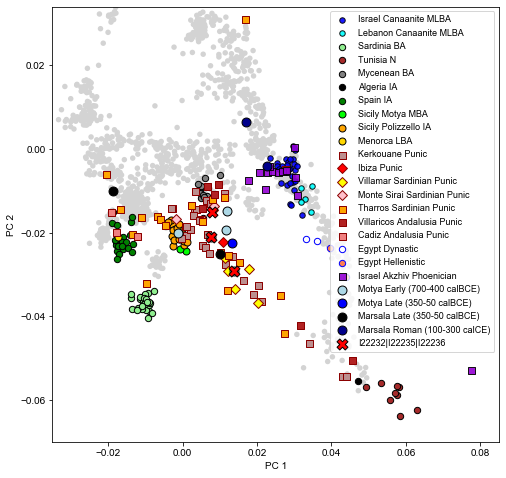

In [8]:
plot_pca_sample(iid=["I22232|I22235|I22236"], savepath="") # Caramelli Phoenician: I22232 I22235 I22236

### Save all Individual Sicily Samples
Runs about 2 min

Italy_Sicily_Roman Found: 2/2042
I4800|I22232|I22236|I4798|I4799 IIDs: 5/2042
I12844 IIDs: 1/2042
I8577|I7454 IIDs: 2/2042
I12849|I7265 IIDs: 2/2042
I12664 IIDs: 1/2042
Saved to: /n/groups/reich/hringbauer/git/punic_aDNA/figures/pca.v46/sic_inds/I12664.pdf
I4800|I22232|I22236|I4798|I4799 IIDs: 5/2042
I12844 IIDs: 1/2042
I8577|I7454 IIDs: 2/2042
I12849|I7265 IIDs: 2/2042
I12849 IIDs: 1/2042
Saved to: /n/groups/reich/hringbauer/git/punic_aDNA/figures/pca.v46/sic_inds/I12849.pdf


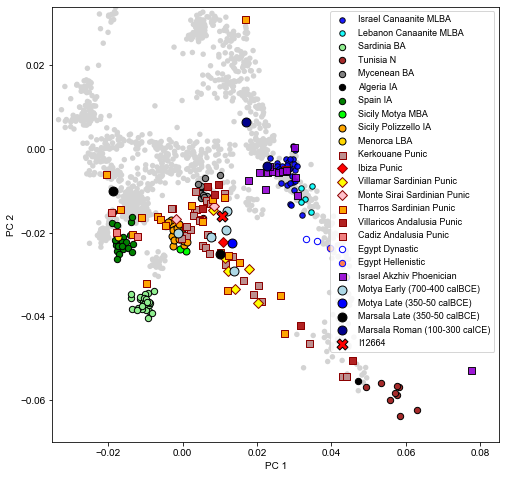

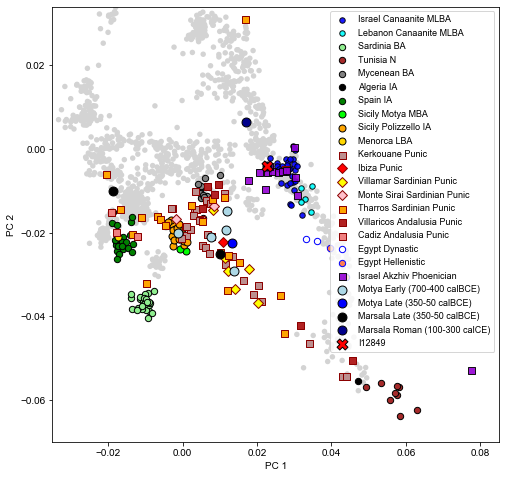

In [14]:
df_plot = get_sub_pops(df, ["Italy_Sicily_Roman"])

for iid in df_plot["iid"].values:
    savepath = f"/n/groups/reich/hringbauer/git/punic_aDNA/figures/pca.v46/sic_inds/{iid}.pdf"
    plot_pca_sample(iid=[iid], savepath=savepath, show=False) # Caramelli Phoenician: I22232 I22235 I22236

In [ ]:
plot_pca_sample()

### Dated Motya Sample, context 6th century BCE, local Sicilian ancestry

I4800|I22232|I22236|I4798|I4799 IIDs: 5/2042
I12844 IIDs: 1/2042
I8577|I7454 IIDs: 2/2042
I12849|I7265 IIDs: 2/2042
I12665|I21856|I24554|I22000 IIDs: 4/2042


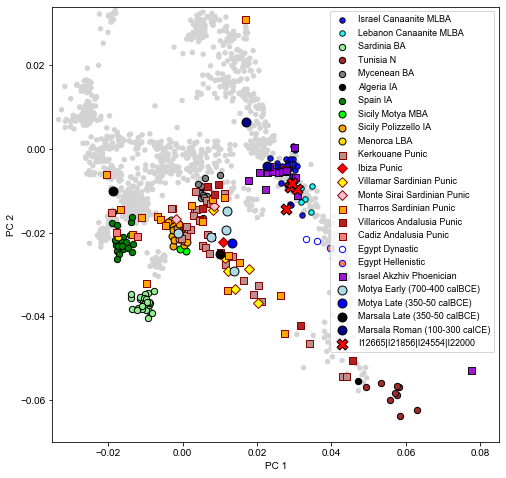

In [48]:
plot_pca_sample(iid=["I12665|I21856|I24554|I22000"], savepath="") # Caramelli Phoenician: I22232 I22235 I22236

I4800|I22232|I22236|I4798|I4799 IIDs: 5/2042
I12844 IIDs: 1/2042
I8577|I7454 IIDs: 2/2042
I12849|I7265 IIDs: 2/2042
I12666 IIDs: 1/2042


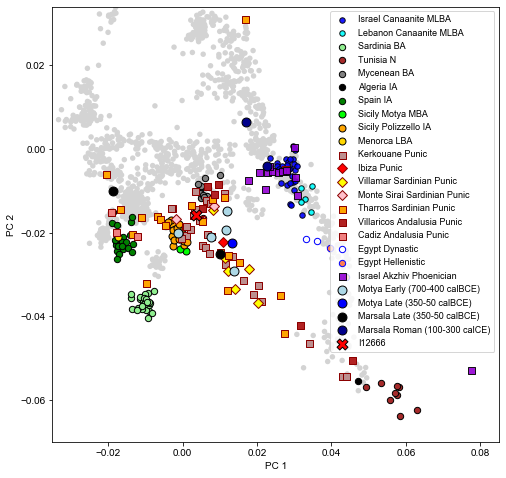

In [65]:
plot_pca_sample(iid=["I12666"], savepath="") 

# Marsala by contributor

Saved to: ./figures/pca.v46/marsala.pdf


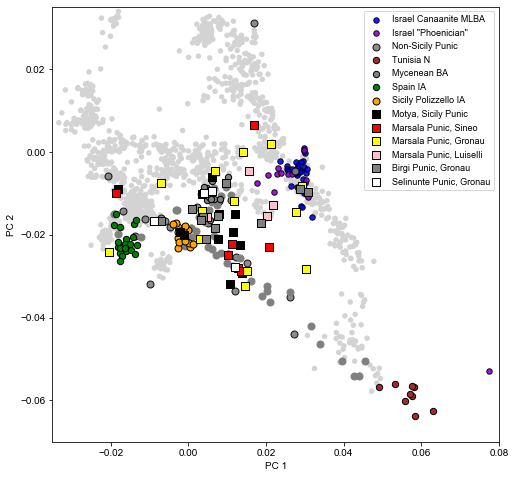

In [96]:
#savepath="./figures/pca/west_med_punic_pca.pdf"
#savepath="./figures/pca.v46/tharros.pdf"
savepath="./figures/pca.v46/marsala.pdf"

plt.figure(figsize=(8,8))
ax = plt.gca()

plot_pca_ho(ax, df_ho, c="lightgray", text=False)
plot_pca(ax, df_is, c="blue", legend="Israel Canaanite MLBA", ec="k", alpha=0.9)
#plot_pca(ax, df_le, c="aqua", legend="Lebanon Canaanite MLBA", ec="k", alpha=0.9)
plot_pca(ax, df_isp, c="darkviolet", legend="Israel \"Phoenician\"", ec="k", alpha=0.9)
### Plot the Sardinian Samples
#plot_pca(ax, df_sard_ba, c="lightgreen", legend="Sardinia BA", ec="k", s=40)

plot_pca(ax, df_sard, c="gray", legend="Non-Sicily Punic", ec="k", s=49, marker="o", text=False, alpha=0.9)
#plot_pca(ax, df_sard1, c="orange", legend="Tharros Sardinian Roman/Punic", ec="red", s=49, marker="s", text=False)

plot_pca(ax, df_vill, c="gray", legend="", ec="gray", s=49, marker="o", text=False)
plot_pca(ax, df_cad, c="gray", legend="", ec="gray", s=49, marker="o", text=False)
plot_pca(ax, df_kerk, c="gray", legend="", ec="gray", s=49, marker="o", text=False)



plot_pca(ax, df_tun, c="brown", legend="Tunisia N", ec="k", s=40)
plot_pca(ax, df_greek, c="gray", legend="Mycenean BA", ec="k", s=40)

#plot_pca(ax, df_alg, c="k", legend="Algeria IA", s=40, ec="k")
plot_pca(ax, df_spain, c="green", legend="Spain IA", s=40, ec="k")

plot_pca(ax, df_sic_ia, c="orange", legend="Sicily Polizzello IA", s=49, ec="k")
#plot_pca(ax, df_meno, c="gold", legend="Menorca LBA", ec="k", s=49)

#plot_pca(ax, df_ib, c="red", legend="Ibiza Punic", ec="darkred", s=49, marker="D")
#plot_pca(ax, df_vil, c="yellow", legend="Villamar Sardinian Punic", ec="darkred", s=49, marker="D")
#plot_pca(ax, df_msr, c="pink", legend="Monte Sirai Sardinian Punic", ec="darkred", s=49, marker="D")

### Plot the Re
plot_pca(ax, df_mot, c="k", legend="Motya, Sicily Punic", ec="k", s=60, marker="s", text=False)
#plot_pca(ax, df_mar, c="green", legend="Marsala, Sicily Punic", ec="k", s=90, marker="o", text=False)

df_sin = df_mar[df_mar["contact"].str.contains("Sineo")]
df_gron = df_mar[df_mar["contact"].str.contains("Gronau")]
df_luis = df_mar[df_mar["contact"].str.contains("Luiselli")]

plot_pca(ax, df_sin, c="red", legend="Marsala Punic, Sineo", ec="k", s=60, marker="s", text=False)
plot_pca(ax, df_gron, c="yellow", legend="Marsala Punic, Gronau", ec="k", s=60, marker="s", text=False)
plot_pca(ax, df_luis, c="pink", legend="Marsala Punic, Luiselli", ec="k", s=60, marker="s", text=False)
plot_pca(ax, df_bir, c="gray", legend="Birgi Punic, Gronau", ec="k", s=60, marker="s", text=False)

plot_pca(ax, df_sel, c="white", legend="Selinunte Punic, Gronau", ec="k", s=60, marker="s", text=False)


plot_pca(ax, df_sic_ia, c="orange", legend="Sicily Polizzello IA", s=49, ec="k")

ax.legend(loc="upper right", fontsize=9)
ax.set_xlabel("PC 1")
ax.set_ylabel("PC 2")
ax.set_xlim([-0.035,0.08])
ax.set_ylim([-0.07,0.035])

if len(savepath) > 0:
    plt.savefig(savepath, bbox_inches = 'tight', 
                pad_inches = 0, dpi=600)
    print(f"Saved to: {savepath}")
    
plt.show()

In [60]:
df_mar["contact"].value_counts()

Gronau, Ilan        13
Sineo, Luca          7
Luiselli, Donata     4
Name: contact, dtype: int64

# Highlight Consanguineous Individuals

Found: 5/2042
Found: 3/2042
Found: 3/2042


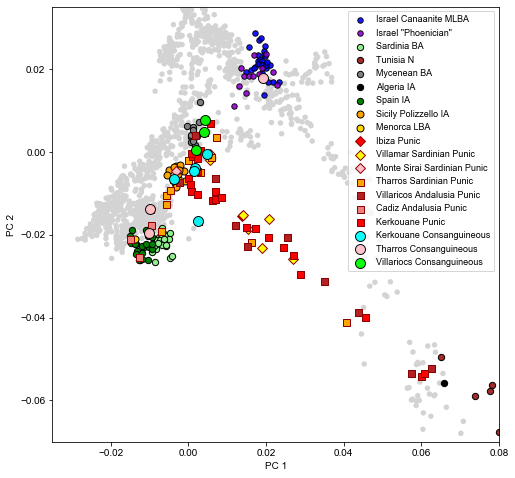

In [130]:
#savepath="./figures/pca/west_med_punic_pca.pdf"
iid = "I24041|I24190|I24045|I24196|I24193"
iid2 = "I22121|I22119|I21964"
iid3 = "I18199|I18201|I18203"
savepath=f"./figures/pca.v45/consagnuineous_pca.pdf"
savepath=""

df_iid = get_sub_iid(df, [iid])
df_iid2 = get_sub_iid(df, [iid2])
df_iid3 = get_sub_iid(df, [iid3])

plt.figure(figsize=(8,8))
ax = plt.gca()

plot_pca_ho(ax, df_ho, c="lightgray", text=False)
plot_pca(ax, df_is, c="blue", legend="Israel Canaanite MLBA", ec="k", alpha=0.9)
#plot_pca(ax, df_le, c="aqua", legend="Lebanon Canaanite MLBA", ec="k", alpha=0.9)
plot_pca(ax, df_isp, c="darkviolet", legend="Israel \"Phoenician\"", ec="k", alpha=0.9)
### Plot the Sardinian Samples
plot_pca(ax, df_sard_ba, c="lightgreen", legend="Sardinia BA", ec="k", s=40)
plot_pca(ax, df_tun, c="brown", legend="Tunisia N", ec="k", s=40)
plot_pca(ax, df_greek, c="gray", legend="Mycenean BA", ec="k", s=40)

plot_pca(ax, df_alg, c="k", legend="Algeria IA", s=40, ec="k")
plot_pca(ax, df_spain, c="green", legend="Spain IA", s=40, ec="k")

plot_pca(ax, df_sic_ia, c="orange", legend="Sicily Polizzello IA", s=49, ec="k")


plot_pca(ax, df_meno, c="gold", legend="Menorca LBA", ec="k", s=49)
plot_pca(ax, df_ib, c="red", legend="Ibiza Punic", ec="darkred", s=49, marker="D")

plot_pca(ax, df_vil, c="yellow", legend="Villamar Sardinian Punic", ec="darkred", s=49, marker="D")
plot_pca(ax, df_msr, c="pink", legend="Monte Sirai Sardinian Punic", ec="darkred", s=49, marker="D")

plot_pca(ax, df_sard, c="orange", legend="Tharros Sardinian Punic", ec="darkred", s=49, marker="s", text=False)
#plot_pca(ax, df_sard1, c="orange", legend="Tharros Sardinian Roman/Punic", ec="red", s=49, marker="s", text=False)

plot_pca(ax, df_vill, c="firebrick", legend="Villaricos Andalusia Punic", ec="darkred", s=49, marker="s", text=False)
plot_pca(ax, df_cad, c="lightcoral", legend="Cadiz Andalusia Punic", ec="darkred", s=49, marker="s", text=False)

plot_pca(ax, df_kerk, c="red", legend="Kerkouane Punic", ec="darkred", s=49, marker="s", text=False)
plot_pca(ax, df_iid, c="cyan", legend=f"Kerkouane Consanguineous", ec="k", alpha=0.95, s=100)
plot_pca(ax, df_iid2, c="pink", legend=f"Tharros Consanguineous", ec="k", alpha=0.95, s=100)
plot_pca(ax, df_iid3, c="lime", legend=f"Villariocs Consanguineous", ec="k", alpha=0.95, s=100)

ax.legend(loc="upper right", fontsize=9)
ax.set_xlabel("PC 1")
ax.set_ylabel("PC 2")
ax.set_xlim([-0.035,0.08])
ax.set_ylim([-0.07,0.035])

if len(savepath) > 0:
    plt.savefig(savepath, bbox_inches = 'tight', 
                pad_inches = 0, dpi=600)
    print(f"Saved to: {savepath}")
    
plt.show()

# Plot single individual

I12847|I24213 IIDs: 2/2042


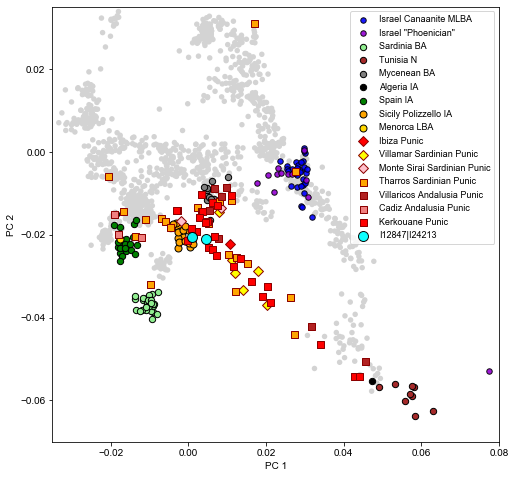

In [30]:
#savepath="./figures/pca/west_med_punic_pca.pdf"
iid = "I12847|I24213"  ### Tunisia - Sicilly relative!
#iid = "I22122|I22118|I22117"  # Relatives Tharros
#iid = "I22122"
#savepath=f"./figures/pca.v45/kerkouane_ROH_pca.pdf"
savepath=""

df_iid = get_sub_iid(df, [iid])

plt.figure(figsize=(8,8))
ax = plt.gca()

plot_pca_ho(ax, df_ho, c="lightgray", text=False)
plot_pca(ax, df_is, c="blue", legend="Israel Canaanite MLBA", ec="k", alpha=0.9)
#plot_pca(ax, df_le, c="aqua", legend="Lebanon Canaanite MLBA", ec="k", alpha=0.9)
plot_pca(ax, df_isp, c="darkviolet", legend="Israel \"Phoenician\"", ec="k", alpha=0.9)
### Plot the Sardinian Samples
plot_pca(ax, df_sard_ba, c="lightgreen", legend="Sardinia BA", ec="k", s=40)
plot_pca(ax, df_tun, c="brown", legend="Tunisia N", ec="k", s=40)
plot_pca(ax, df_greek, c="gray", legend="Mycenean BA", ec="k", s=40)

plot_pca(ax, df_alg, c="k", legend="Algeria IA", s=40, ec="k")
plot_pca(ax, df_spain, c="green", legend="Spain IA", s=40, ec="k")

plot_pca(ax, df_sic_ia, c="orange", legend="Sicily Polizzello IA", s=49, ec="k")


plot_pca(ax, df_meno, c="gold", legend="Menorca LBA", ec="k", s=49)
plot_pca(ax, df_ib, c="red", legend="Ibiza Punic", ec="darkred", s=49, marker="D")

plot_pca(ax, df_vil, c="yellow", legend="Villamar Sardinian Punic", ec="darkred", s=49, marker="D")
plot_pca(ax, df_msr, c="pink", legend="Monte Sirai Sardinian Punic", ec="darkred", s=49, marker="D")

plot_pca(ax, df_sard, c="orange", legend="Tharros Sardinian Punic", ec="darkred", s=49, marker="s", text=False)

plot_pca(ax, df_vill, c="firebrick", legend="Villaricos Andalusia Punic", ec="darkred", s=49, marker="s", text=False)
plot_pca(ax, df_cad, c="lightcoral", legend="Cadiz Andalusia Punic", ec="darkred", s=49, marker="s", text=False)

plot_pca(ax, df_kerk, c="red", legend="Kerkouane Punic", ec="darkred", s=49, marker="s", text=False)
plot_pca(ax, df_iid, c="cyan", legend=f"{iid}", ec="k", alpha=0.95, s=100)

ax.legend(loc="upper right", fontsize=9)
ax.set_xlabel("PC 1")
ax.set_ylabel("PC 2")
ax.set_xlim([-0.035,0.08])
ax.set_ylim([-0.07,0.035])

if len(savepath) > 0:
    plt.savefig(savepath, bbox_inches = 'tight', 
                pad_inches = 0, dpi=600)
    print(f"Saved to: {savepath}")
    
plt.show()

In [ ]:
df_vill.sort_values(by="pc2")

In [ ]:
#savepath="./figures/pca/west_med_punic_pca.pdf"
iid = "I22121"
#savepath=f"./figures/pca.v45/kerkouane_ROH_pca.pdf"
savepath=""

df_iid = get_sub_iid(df, [iid])

plt.figure(figsize=(8,8))
ax = plt.gca()

plot_pca_ho(ax, df_ho, c="lightgray", text=False)
plot_pca(ax, df_is, c="blue", legend="Israel Canaanite MLBA", ec="k", alpha=0.9)
#plot_pca(ax, df_le, c="aqua", legend="Lebanon Canaanite MLBA", ec="k", alpha=0.9)
plot_pca(ax, df_isp, c="darkviolet", legend="Israel \"Phoenician\"", ec="k", alpha=0.9)
### Plot the Sardinian Samples
plot_pca(ax, df_sard_ba, c="lightgreen", legend="Sardinia BA", ec="k", s=40)
plot_pca(ax, df_tun, c="brown", legend="Tunisia N", ec="k", s=40)
plot_pca(ax, df_greek, c="gray", legend="Mycenean BA", ec="k", s=40)

plot_pca(ax, df_alg, c="k", legend="Algeria IA", s=40, ec="k")
plot_pca(ax, df_spain, c="green", legend="Spain IA", s=40, ec="k")

plot_pca(ax, df_sic_ia, c="orange", legend="Sicily Polizzello IA", s=49, ec="k")



plot_pca(ax, df_meno, c="gold", legend="Menorca LBA", ec="k", s=49)
plot_pca(ax, df_ib, c="red", legend="Ibiza Punic", ec="darkred", s=49, marker="D")

plot_pca(ax, df_vil, c="yellow", legend="Villamar Sardinian Punic", ec="darkred", s=49, marker="D")
plot_pca(ax, df_msr, c="pink", legend="Monte Sirai Sardinian Punic", ec="darkred", s=49, marker="D")

plot_pca(ax, df_sard, c="orange", legend="Tharros Sardinian Punic", ec="darkred", s=49, marker="s", text=False)
plot_pca(ax, df_sard1, c="orange", legend="Tharros Sardinian Roman/Punic", ec="red", s=49, marker="s", text=False)

plot_pca(ax, df_vill, c="firebrick", legend="Villaricos Andalusia Punic", ec="darkred", s=49, marker="s", text=False)
plot_pca(ax, df_cad, c="lightcoral", legend="Cadiz Andalusia Punic", ec="darkred", s=49, marker="s", text=False)

plot_pca(ax, df_kerk, c="red", legend="Kerkouane Punic", ec="darkred", s=49, marker="s", text=False)
plot_pca(ax, df_iid, c="cyan", legend=f"{iid}", ec="k", alpha=0.95, s=100)

ax.legend(loc="upper right", fontsize=9)
ax.set_xlabel("PC 1")
ax.set_ylabel("PC 2")
ax.set_xlim([-0.035,0.08])
ax.set_ylim([-0.07,0.035])

if len(savepath) > 0:
    plt.savefig(savepath, bbox_inches = 'tight', 
                pad_inches = 0, dpi=600)
    print(f"Saved to: {savepath}")
    
plt.show()

In [ ]:
df_kerk.sort_values(by="pc2")

# Sicilian Punic

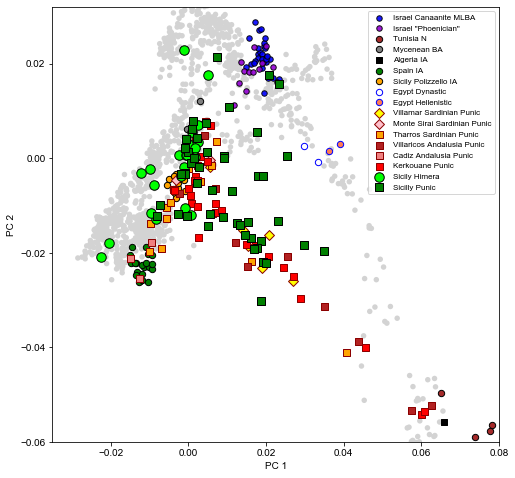

In [133]:
savepath="./figures/pca.v46/pca_sicilly_punic.png"
savepath=""

plt.figure(figsize=(8,8))
ax = plt.gca()

plot_pca(ax, df_ho, c="lightgray")

plot_pca(ax, df_is, c="blue", legend="Israel Canaanite MLBA", ec="k", alpha=0.9)
#plot_pca(ax, df_le, c="aqua", legend="Lebanon Canaanite MLBA", ec="k", alpha=0.9)
plot_pca(ax, df_isp, c="darkviolet", legend="Israel \"Phoenician\"", ec="k", alpha=0.9)
### Plot the Sardinian Samples
#plot_pca(ax, df_sard_ba, c="lightgreen", legend="Sardinia BA", ec="k", s=40)
plot_pca(ax, df_tun, c="brown", legend="Tunisia N", ec="k", s=40)
plot_pca(ax, df_greek, c="gray", legend="Mycenean BA", ec="k", s=40)

plot_pca(ax, df_alg, c="k", legend="Algeria IA", s=40, marker="s", ec="k")
plot_pca(ax, df_spain, c="green", legend="Spain IA", s=40, ec="k")
plot_pca(ax, df_sic_ia, c="orange", legend="Sicily Polizzello IA", s=40, ec="k")

plot_pca(ax, df_eg_dyn, c="w", legend="Egypt Dynastic", ec="blue", s=40, marker="o")
plot_pca(ax, df_eg_hell, c="coral", legend="Egypt Hellenistic", ec="blue", s=40, marker="o")

#plot_pca(ax, df_sard, c="orange", legend="Tharros Sardinian Punic", ec="darkred", s=50, marker="s")
#plot_pca(ax, df_vil, c="yellow", legend="Villamar Sardinian Punic", ec="darkred", s=50, marker="s")
#plot_pca(ax, df_msr, c="maroon", legend="Monte Sirai Sardinian Punic", ec="darkred", s=50, marker="s")

#plot_pca(ax, df_vill, c="red", legend="Andalusia Villaricos Punic", ec="darkred", s=50, marker="D")
#plot_pca(ax, df_ib, c="red", legend="Ibiza Punic", ec="sandybrown", s=70, marker="*")

#plot_pca(ax, df_sic, c="w", legend="Sicilly Punic", ec="blue", s=70, marker="s")
plot_pca(ax, df_vil, c="yellow", legend="Villamar Sardinian Punic", ec="darkred", s=49, marker="D")
plot_pca(ax, df_msr, c="pink", legend="Monte Sirai Sardinian Punic", ec="darkred", s=49, marker="D")

plot_pca(ax, df_sard, c="orange", legend="Tharros Sardinian Punic", ec="darkred", s=49, marker="s", text=False)

plot_pca(ax, df_vill, c="firebrick", legend="Villaricos Andalusia Punic", ec="darkred", s=49, marker="s", text=False)
plot_pca(ax, df_cad, c="lightcoral", legend="Cadiz Andalusia Punic", ec="darkred", s=49, marker="s", text=False)
plot_pca(ax, df_kerk, c="red", legend="Kerkouane Punic", ec="darkred", s=49, marker="s", text=False)


plot_pca(ax, df_sic_him, c="lime", legend="Sicily Himera", s=90, marker="o", ec="k")
plot_pca(ax, df_sic2, c="green", legend="Sicilly Punic", ec="k", s=70, marker="s")


ax.legend(loc="upper right", fontsize=8)
ax.set_xlabel("PC 1")
ax.set_ylabel("PC 2")
ax.set_xlim([-0.035,0.08])
ax.set_ylim([-0.06,0.032])

if len(savepath) > 0:
    plt.savefig(savepath, bbox_inches = 'tight', 
                pad_inches = 0, dpi=600)
    print(f"Saved to: {savepath}")
    
plt.show()

In [ ]:
df_meta[df_meta["clst"].str.contains("Phoen")].sort_values(by="age")

### Sicilly by Site

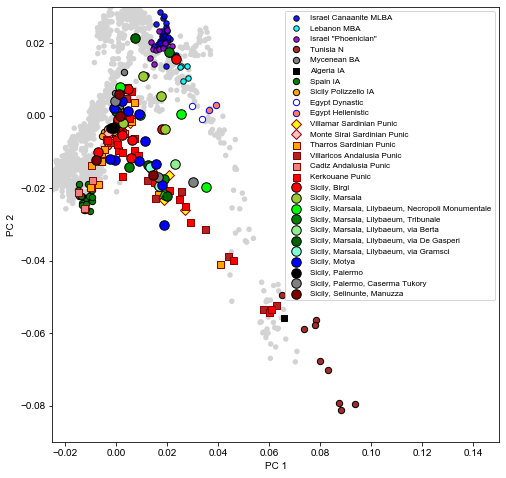

In [136]:
savepath="./figures/pca.v46/pca_sicilly_punic.png"
savepath = "./figures/pca.v46/pca_sicilly_punic.pdf"
savepath = ""

plt.figure(figsize=(8,8))
ax = plt.gca()

plot_pca(ax, df_ho, c="lightgray")

plot_pca(ax, df_is, c="blue", legend="Israel Canaanite MLBA", ec="k", alpha=0.9)
plot_pca(ax, df_le, c="aqua", legend="Lebanon MBA", ec="k", alpha=0.9)
plot_pca(ax, df_isp, c="darkviolet", legend="Israel \"Phoenician\"", ec="k", alpha=0.9)
### Plot the Sardinian Samples
#plot_pca(ax, df_sard_ba, c="lightgreen", legend="Sardinia BA", ec="k", s=40)
plot_pca(ax, df_tun, c="brown", legend="Tunisia N", ec="k", s=40)
plot_pca(ax, df_greek, c="gray", legend="Mycenean BA", ec="k", s=40)

plot_pca(ax, df_alg, c="k", legend="Algeria IA", s=40, marker="s", ec="k")
plot_pca(ax, df_spain, c="green", legend="Spain IA", s=40, ec="k")
plot_pca(ax, df_sic_ia, c="orange", legend="Sicily Polizzello IA", s=40, ec="k")

plot_pca(ax, df_eg_dyn, c="w", legend="Egypt Dynastic", ec="blue", s=40, marker="o")
plot_pca(ax, df_eg_hell, c="coral", legend="Egypt Hellenistic", ec="blue", s=40, marker="o")

#plot_pca(ax, df_vill, c="red", legend="Andalusia Villaricos Punic", ec="darkred", s=50, marker="D")
#plot_pca(ax, df_ib, c="red", legend="Ibiza Punic", ec="sandybrown", s=70, marker="*")

#plot_pca(ax, df_sic, c="w", legend="Sicilly Punic", ec="blue", s=70, marker="s")
plot_pca(ax, df_vil, c="yellow", legend="Villamar Sardinian Punic", ec="darkred", s=49, marker="D")
plot_pca(ax, df_msr, c="pink", legend="Monte Sirai Sardinian Punic", ec="darkred", s=49, marker="D")

plot_pca(ax, df_sard, c="orange", legend="Tharros Sardinian Punic", ec="darkred", s=49, marker="s", text=False)

plot_pca(ax, df_vill, c="firebrick", legend="Villaricos Andalusia Punic", ec="darkred", s=49, marker="s", text=False)
plot_pca(ax, df_cad, c="lightcoral", legend="Cadiz Andalusia Punic", ec="darkred", s=49, marker="s", text=False)
plot_pca(ax, df_kerk, c="red", legend="Kerkouane Punic", ec="darkred", s=49, marker="s", text=False)


#plot_pca(ax, df_sic_him, c="lime", legend="Sicily Himera", s=90, marker="o", ec="k")
#plot_pca(ax, df_sic2, c="green", legend="Sicilly Punic", ec="k", s=70, marker="s")

locs, dfs = split_up_df(df = df_sic2, col="loc")
cs = ["red", "yellowgreen", "lime", "green", "lightgreen", 
      "darkgreen", "aquamarine", "blue", "black", "gray", "maroon"]
for i in range(len(locs)):
    plot_pca(ax, dfs[i], c=cs[i], legend=locs[i], s=90, marker="o", ec="k")
    


ax.legend(loc="upper right", fontsize=8)
ax.set_xlabel("PC 1")
ax.set_ylabel("PC 2")
ax.set_xlim([-0.025,0.15])
ax.set_ylim([-0.09,0.03])

if len(savepath) > 0:
    plt.savefig(savepath, bbox_inches = 'tight', 
                pad_inches = 0, dpi=600)
    print(f"Saved to: {savepath}")
    
plt.show()

# Plot context

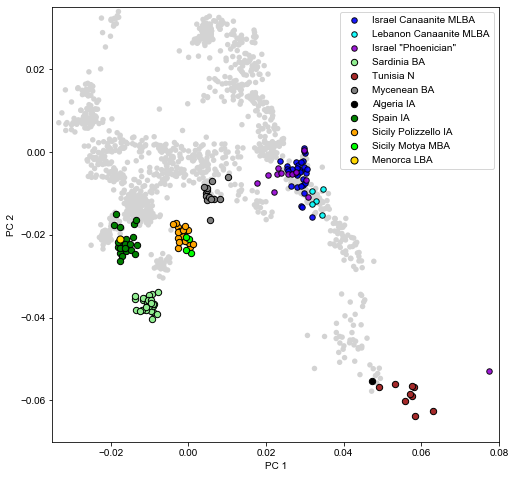

In [118]:
#savepath="./figures/pca/west_med_punic_pca.pdf"
savepath="./figures/pca/west_med_context.png"
savepath=""

plt.figure(figsize=(8,8))
ax = plt.gca()

plot_pca_ho(ax, df_ho, c="lightgray", text=False)
plot_pca(ax, df_is, c="blue", legend="Israel Canaanite MLBA", ec="k", alpha=0.9)
plot_pca(ax, df_le, c="aqua", legend="Lebanon Canaanite MLBA", ec="k", alpha=0.9)
plot_pca(ax, df_isp, c="darkviolet", legend="Israel \"Phoenician\"", ec="k", alpha=0.9)
### Plot the Sardinian Samples
plot_pca(ax, df_sard_ba, c="lightgreen", legend="Sardinia BA", ec="k", s=40)
plot_pca(ax, df_tun, c="brown", legend="Tunisia N", ec="k", s=40)
plot_pca(ax, df_greek, c="gray", legend="Mycenean BA", ec="k", s=40)

plot_pca(ax, df_alg, c="k", legend="Algeria IA", s=40, ec="k")
plot_pca(ax, df_spain, c="green", legend="Spain IA", s=40, ec="k")

plot_pca(ax, df_sic_ia, c="orange", legend="Sicily Polizzello IA", s=40, ec="k")
plot_pca(ax, df_sic_mba, c="lime", legend="Sicily Motya MBA", s=40, ec="k")
plot_pca(ax, df_meno, c="gold", legend="Menorca LBA", ec="k", s=50, marker="o")

#plot_pca(ax, df_sic, c="w", legend="Sicilly Punic", ec="blue", s=70, marker="s")
#plot_pca(ax, df_sic2, c="coral", legend="Sicilly Punic2", ec="blue", s=70, marker="s")
#plot_pca(ax, df_sic_him, c="red", legend="Sicily Himera", s=90, marker="o", ec="k")

#plot_pca(ax, df_sic, c="k", legend="Sicilly Punic", ec="blue", s=70, marker=">")
#plot_pca(ax, df_sic2, c="coral", legend="Sicilly Punic2", ec="blue", s=70, marker=">")

ax.legend(loc="upper right", fontsize=10)
ax.set_xlabel("PC 1")
ax.set_ylabel("PC 2")
ax.set_xlim([-0.035,0.08])
ax.set_ylim([-0.07,0.035])

if len(savepath) > 0:
    plt.savefig(savepath, bbox_inches = 'tight', 
                pad_inches = 0, dpi=600)
    print(f"Saved to: {savepath}")
    
plt.show()

# Africa

In [137]:
### Play with pulling out sample
df[df["pop"].str.contains("Africa")]["pop"].value_counts()

Italy_Sardinia_Punic_oNAfrica          4
Italy_Sicily_unknown_oAfrican          2
Spain_Vandal_Visigoth_oAfrican1        2
Spain_Punic_oAfrican2                  2
Spain_Punic_Roman_oAfrican3            1
Spain_BellBeaker_oAfrican              1
Italy_Sardinia_C_oAfrican              1
Spain_Vandal_Visigoth_oAfrican2        1
Tunisia_Punic_oAfrica                  1
Spain_EBA_Africa_all                   1
Italy_Sicily_LA_Jewish_oHighAfrican    1
Italy_Sicily_MBA_oAfrican              1
Name: pop, dtype: int64

In [124]:
df_alg_IA = get_sub_pops(df, pop_list=["Algeria_IA"])
df_alg_N = get_sub_pops(df, pop_list=["Algeria_N"])
df_ibero_m = get_sub_pops(df, pop_list=["Morocco_Iberomaurusian"])
df_mor_EN = get_sub_pops(df, pop_list=["Morocco_EN"])
df_mor_LN = get_sub_pops(df, pop_list=["Morocco_LN"])
df_sar_afr = get_sub_pops_exact(df, pop_list=["Italy_Sardinia_C_oAfrican"])
df_spain_afr = get_sub_pops_exact(df, pop_list=["Spain_BellBeaker_oAfrican"])
df_sicily_afr = get_sub_pops_exact(df, pop_list=["Italy_Sicily_MBA_oAfrican"])

Algeria_IA Found: 1/2042
Algeria_N Found: 1/2042
Morocco_Iberomaurusian Found: 7/2042
Morocco_EN Found: 3/2042
Morocco_LN Found: 3/2042
Found ['Italy_Sardinia_C_oAfrican'] (exact): 1/2042
Found ['Spain_BellBeaker_oAfrican'] (exact): 1/2042
Found ['Italy_Sicily_MBA_oAfrican'] (exact): 1/2042


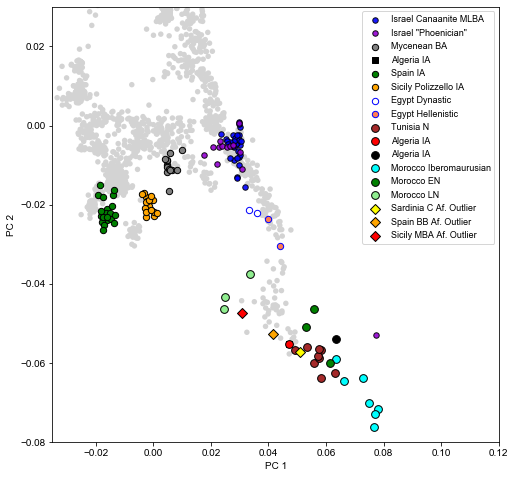

In [127]:
savepath="./figures/pca.v46/pca_afr_punic.png"
savepath=""

plt.figure(figsize=(8,8))
ax = plt.gca()

plot_pca(ax, df_ho, c="lightgray")

plot_pca(ax, df_is, c="blue", legend="Israel Canaanite MLBA", ec="k", alpha=0.9)
#plot_pca(ax, df_le, c="aqua", legend="Lebanon Canaanite MLBA", ec="k", alpha=0.9)
plot_pca(ax, df_isp, c="darkviolet", legend="Israel \"Phoenician\"", ec="k", alpha=0.9)
### Plot the Sardinian Samples
#plot_pca(ax, df_sard_ba, c="lightgreen", legend="Sardinia BA", ec="k", s=40)

plot_pca(ax, df_greek, c="gray", legend="Mycenean BA", ec="k", s=40)

plot_pca(ax, df_alg, c="k", legend="Algeria IA", s=40, marker="s", ec="k")
plot_pca(ax, df_spain, c="green", legend="Spain IA", s=40, ec="k")
plot_pca(ax, df_sic_ia, c="orange", legend="Sicily Polizzello IA", s=40, ec="k")

plot_pca(ax, df_eg_dyn, c="w", legend="Egypt Dynastic", ec="blue", s=40, marker="o")
plot_pca(ax, df_eg_hell, c="coral", legend="Egypt Hellenistic", ec="blue", s=40, marker="o")


plot_pca(ax, df_tun, c="brown", legend="Tunisia N", ec="k", s=60)
plot_pca(ax, df_alg_IA, c="red", legend="Algeria IA", ec="k", s=60)
plot_pca(ax, df_alg_N, c="k", legend="Algeria IA", ec="k", s=60)
plot_pca(ax, df_ibero_m, c="cyan", legend="Morocco Iberomaurusian", ec="k", s=60)
plot_pca(ax, df_mor_EN, c="green", legend="Morocco EN", ec="k", s=60)
plot_pca(ax, df_mor_LN, c="lightgreen", legend="Morocco LN", ec="k", s=60)
plot_pca(ax, df_sar_afr, c="yellow", legend="Sardinia C Af. Outlier", ec="k", s=50, marker="D")
plot_pca(ax, df_spain_afr, c="orange", legend="Spain BB Af. Outlier", ec="k", s=50, marker="D")
plot_pca(ax, df_sicily_afr, c="red", legend="Sicily MBA Af. Outlier", ec="k", s=50, marker="D")


ax.legend(loc="upper right", fontsize=9)
ax.set_xlabel("PC 1")
ax.set_ylabel("PC 2")
ax.set_xlim([-0.035,0.12])
ax.set_ylim([-0.08,0.03])

plt.show()

In [ ]:
df_isp.sort_values(by="pc2")

# Find close PCA matches

In [70]:
def return_pca_matches(df, iid="I22119",
                   pcs = ["pc1", "pc2", "pc3", "pc4"]):
    """Return matches in pc space to sample iid.
    Report sorted dataframe"""
    pc_t = df[df["iid"]==iid][pcs]
    diffs = df[pcs]-pc_t.values
    diff_sq = np.sum(diffs**2,axis=1)
    idx = diff_sq.sort_values().index
    return df.iloc[idx,:].copy()

In [ ]:
return_pca_matches(df, iid="I22125")[:10]

In [ ]:
return_pca_matches(df, iid="I18187")[:30]

In [36]:
idx

Int64Index([1952,  934,  149,  955,  948,  153,  954,  953,  947,  604,
            ...
            1457, 1454, 1458,   15,   22,   18, 1693, 1692, 1440, 1439],
           dtype='int64', length=1899)

### Area 51

In [23]:
df["iid"][df["iid"].str.contains("I22118")]

1956    I22118
Name: iid, dtype: object

In [ ]:
df1 = df[df["pop"].str.contains("Sic")]
df1["pop"].value_counts()

In [ ]:
df_sard

In [322]:
base_path = "/n/groups/reich/DAVID/V44/V44.0/v44.0_HO"
ind_path = base_path + ".ind"

df_ho = pd.read_csv(ind_path, delim_whitespace=True, header=None)
df_ho.columns=["iid", "sex", "clst"]
print(f"Loaded {len(df_ho)} Individuals")

Loaded 32828 Individuals


In [22]:
df_ho[df_ho["iid"].str.contains("I22118")]

,iid,pc1,pc2,pc3,pc4,pop,Master ID,n_cov_snp,mean_cov,sex


In [24]:
df_meta[df_meta["iid"].str.contains("I22118")]

,iid,Master ID,lat,lon,age,region,study,clst,mean_cov,n_cov_snp,avg_cov_snp,include_alt,family,sex
6834,I22118,I22118,39.873496,8.441024,2300.0,Italy,Unpublished,Italy_Sardinia_Punic,0.683903,820684,5.509,True,..,M
13391,I22118_d,I22118,39.873496,8.441024,2300.0,Italy,Unpublished,Italy_Sardinia_Punic,0.267762,321314,0.706,True,..,U


In [ ]:
df_meta